# NBA Data Analysis
Author: Dr. Goku Moneymaker


## Housekeeping

### Imports

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from xgboost import  DMatrix
from sklearn.model_selection import train_test_split
import warnings
import json
import os
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from IPython.display import HTML
from bs4 import BeautifulSoup
import time
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

chrome_options = Options()
chrome_options.add_argument("--headless=new") 
TODAY_FILE = os.listdir('../live_data/')[0]
data_dir = '../historical_data'
live_data_dir = '../live_data'

with open('../config/column_mappings.json', 'r') as file:
    column_mappings = json.load(file)

# Now, you can access your column lists like this
COLS = column_mappings['COLS']
cleaned_cols = column_mappings['cleaned_cols']
t_cleaned_cols = column_mappings['t_cleaned_cols']
TRAIN_COLS = column_mappings['TRAIN_COLS']
today_mappings = column_mappings['today_mappings']
TARGET = column_mappings['TARGET']
SEASON_MAP = column_mappings['SEASON_MAP']
t_train_cols = column_mappings['t_train_cols']
train_cols_final = column_mappings['train_cols_final']

warnings.filterwarnings('ignore')

#### Pull live odds and refs

#### Get the odds

In [13]:
def scrape_dynamic_content(url, delay=10):
    # Initialize the WebDriver
    
    driver = webdriver.Chrome(options=chrome_options)

    # Navigate to the URL
    driver.get(url)

    # Wait for JavaScript to load
    time.sleep(delay)

    # Get the HTML content of the page
    html_content = driver.page_source

    # Close the browser
    driver.quit()

    # Parse the HTML using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all relevant div elements
    elements = soup.find_all('div', class_='flex p-0')

    data = []

    for element in elements:
        try:
            team_info = element.find('button', {'data-testid': 'team-name'})
            if team_info:
                team_name = team_info.find('div', class_='text-primary text-description text-primary').get_text(strip=True)
                team_stats = team_info.find('div', class_='text-subdued-primary mt-0.5 text-footnote').get_text(strip=True)

            bets = element.find_all('button', {'data-dd-action-name': 'Add Bet Selections'})
            bet_data = []
            for bet in bets:
                bet_text = bet.get_text(strip=True).split()
                bet_type = bet_text[0] if bet_text else None
                bet_value = bet_text[1] if len(bet_text) > 1 else None
                bet_data.append({'type': bet_type, 'value': bet_value})

            data.append({'team_name': team_name, 'team_stats': team_stats, 'bets': bet_data})
        except:
          pass

    return data

# URL of the page to scrape
url = 'https://espnbet.com/sport/basketball/organization/united-states/competition/nba/featured-page'  # Replace with the actual URL

# Scrape the dynamic content
scraped_data = scrape_dynamic_content(url)

for row in scraped_data:
    print(f"found team: {row['team_name']} at {row['bets'][-1]['type']}")


found team: PHI 76ers at -120
found team: OKC Thunder at Even
found team: MIA Heat at +175
found team: BKN Nets at -220
found team: ATL Hawks at -350
found team: WSH Wizards at +280
found team: LA Lakers at +145
found team: CLE Cavaliers at -175
found team: NO Pelicans at -135
found team: UTA Jazz at +115
found team: DAL Mavericks at -105
found team: LA Clippers at -115


#### Process that into the format we need

In [14]:
def process_betting_data(data, team_city_map):
    output = {}
    for i, item in enumerate(data):
        city = team_city_map.get(item['team_name'], 'Unknown City')
        bets = item['bets']

        opp_ind = i - 1 if i%2 == 1 else i + 1
        venue = 'H' if i % 2 == 1 else 'R'

        # Initialize default values
        moneyline = spread = total = 'BLANK_STRING'

        # Extract the moneyline, spread, and total from the bets
        if bets:
            # Moneyline is the value of 'type' in the last object
            moneyline = bets[-1]['type'] if bets[-1]['value'] is None else bets[-1]['value']

            # Spread is the value before the '-' in the first object
            spread_data = bets[0]['type'][:4] if bets[0]['type'] else ''
            spread = spread_data if spread_data else 'BLANK_STRING'

            # Total is the value before the '-' in the second object
            total_data = bets[1]['value'].split('-')[0] if len(bets) > 1 and bets[1]['value'] else ''
            total = total_data if total_data else 'BLANK_STRING'

        # Construct the output format
        output[city] = ['REF', moneyline, venue, team_city_map.get(data[opp_ind]['team_name']), spread, total]

    return output

team_city_map = {
    'ATL Hawks': 'Atlanta',
    'BKN Nets': 'Brooklyn',
    'BOS Celtics': 'Boston',
    'CHA Hornets': 'Charlotte',
    'CHI Bulls': 'Chicago',
    'CLE Cavaliers': 'Cleveland',
    'DAL Mavericks': 'Dallas',
    'DEN Nuggets': 'Denver',
    'DET Pistons': 'Detroit',
    'GS Warriors': 'Golden State',
    'HOU Rockets': 'Houston',
    'IND Pacers': 'Indiana',
    'LA Clippers': 'LA Clippers',
    'LA Lakers': 'LA Lakers',
    'L.A. Lakers': 'LA Lakers',
    'MEM Grizzlies': 'Memphis',
    'MIA Heat': 'Miami',
    'MIL Bucks': 'Milwaukee',
    'MIN Timberwolves': 'Minnesota',
    'NO Pelicans': 'New Orleans',
    'NY Knicks': 'New York',
    'OKC Thunder': 'Oklahoma City',
    'ORL Magic': 'Orlando',
    'PHI 76ers': 'Philadelphia',
    'PHX Suns': 'Phoenix',
    'POR Trail Blazers': 'Portland',
    'SAC Kings': 'Sacramento',
    'SA Spurs': 'San Antonio',
    'TOR Raptors': 'Toronto',
    'UTA Jazz': 'Utah',
    'WSH Wizards': 'Washington'
}

processed_data = process_betting_data(scraped_data, team_city_map)
print('DONE')

DONE


#### get today's refs and merge that in

In [16]:
def parse_referee_data(html_content, team_city_map):
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table', class_='table')
    rows = table.find_all('tr')[1:]  # Skipping the header row

    ref_data = {}
    for row in rows:
        columns = row.find_all('td')
        if len(columns) < 4:
            continue  # Skip rows that don't have enough columns

        game = columns[0].get_text(strip=True)
        crew_chief = columns[1].get_text(strip=True)
        referee = columns[2].get_text(strip=True)
        umpire = columns[3].get_text(strip=True)

        # Split the game into two teams
        teams = game.split(' @ ')
        if len(teams) != 2:
            continue  # Skip if format is not as expected
        city1 = teams[0] #_city_map.get(teams[0].split()[-1] + " " + teams[0].split()[-2], "Unknown")
        city2 = teams[1] #_city_map.get(teams[1].split()[-1] + " " + teams[1].split()[-2], "Unknown")

        ref_data[city1] = [crew_chief, referee, umpire]
        ref_data[city2] = [crew_chief, referee, umpire]

    return ref_data

driver = webdriver.Chrome(options=chrome_options)
driver.get('https://official.nba.com/referee-assignments/')

# Wait for JavaScript to load
time.sleep(2)

# Get the HTML content of the page
html_content = driver.page_source

# Close the browser
driver.quit()


referee_data = parse_referee_data(html_content, team_city_map)
display(processed_data)
for city, refs in referee_data.items():
    try:
        if city == 'L.A. Lakers':
          city = 'LA Lakers'
        processed_data[city][0] = ' '.join(refs[0].split(' ')[:-1])
        #print(f"{city}: {refs[0].split(' ')[:-1].join(' ')}")
    except:
      pass

TODAY_MAP = processed_data
print('DONE')

{'Philadelphia': ['REF', '-120', 'R', 'Oklahoma City', '-1.5', '231.5'],
 'Oklahoma City': ['REF', 'Even', 'H', 'Philadelphia', '+1.5', '231.5'],
 'Miami': ['REF', '+175', 'R', 'Brooklyn', '+5.5', '216.5'],
 'Brooklyn': ['REF', '-220', 'H', 'Miami', '-5.5', '216.5'],
 'Atlanta': ['REF', '-350', 'R', 'Washington', '-8.5', '250.5'],
 'Washington': ['REF', '+280', 'H', 'Atlanta', '+8.5', '250.5'],
 'LA Lakers': ['REF', '+145', 'R', 'Cleveland', '+4.5', '224.5'],
 'Cleveland': ['REF', '-175', 'H', 'LA Lakers', '-4.5', '224.5'],
 'New Orleans': ['REF', '-135', 'R', 'Utah', '-2.5', '225.5'],
 'Utah': ['REF', '+115', 'H', 'New Orleans', '+2.5', '225.5'],
 'Dallas': ['REF', '-105', 'R', 'LA Clippers', '+1.5', '235.5'],
 'LA Clippers': ['REF', '-115', 'H', 'Dallas', '-1.5', '235.5']}

DONE


## Processing / Prep

### Build dataframe

In [35]:
team_df_2019 = pd.read_excel(f'{data_dir}/2018-2019_NBA_Box_Score_Team-Stats.xlsx')
team_df_2020 = pd.read_excel(f'{data_dir}/2019-2020_NBA_Box_Score_Team-Stats.xlsx')
team_df_2021 = pd.read_excel(f'{data_dir}/2020-2021_NBA_Box_Score_Team-Stats.xlsx')
team_df_2022 = pd.read_excel(f'{data_dir}/2021-2022_NBA_Box_Score_Team-Stats.xlsx')
team_df_2023 = pd.read_excel(f'{data_dir}/2022-2023_NBA_Box_Score_Team-Stats.xlsx')
tdf = pd.read_excel(f'{live_data_dir}/{TODAY_FILE}')
refs_2019 = pd.read_csv(f'{data_dir}/2018-2019.csv')
refs_2020 = pd.read_csv(f'{data_dir}/2019-2020.csv')
refs_2021 = pd.read_csv(f'{data_dir}/2020-2021.csv')
refs_2022 = pd.read_csv(f'{data_dir}/2021_2022.csv')
refs_2023 = pd.read_csv(f'{data_dir}/2022-2023.csv')

refs = pd.concat([refs_2019, refs_2020, refs_2021, refs_2022, refs_2023])
df = pd.concat([team_df_2019, team_df_2020, team_df_2021, team_df_2022, team_df_2023])
df.columns = cleaned_cols
tdf.columns = t_cleaned_cols

rename_map = {
    'OPENING_ODDS': 'OPENING ODDS',
    'FULL_GAME_ODDS_URL': 'ODDS_URL'
    # Add other mappings if there are more discrepancies
}
tdf.rename(columns=rename_map, inplace=True)

# Step 2: Add missing columns in df2 (if any)
missing_cols = set(cleaned_cols) - set(tdf.columns)
for col in missing_cols:
    tdf[col] = pd.NA


# Step 3: Concatenate the DataFrames
df = pd.concat([df, tdf], ignore_index=True)
""" Add additional columns to games df """
df['Season'] = df['BIGDATABALL_DATASET'].map(SEASON_MAP)

# Step 1: Result of the Game
def assign_results(group):
    group['MAIN REF'] = [group['MAIN REF'].iloc[0]]*2
    if group.iloc[0]['PTS'] > group.iloc[1]['PTS']:
        group['Result'] = [1, 0]
    else:
        group['Result'] = [0, 1]

    group['Opp_Avg_3_game_PTS'] = [group.iloc[1]['Avg_3_game_PTS'], group.iloc[0]['Avg_3_game_PTS']]
    group['Opp_Avg_2_game_PTS'] = [group.iloc[1]['Avg_5_game_PTS'], group.iloc[0]['Avg_5_game_PTS']]
    group['Opp_Season_Avg_PTS'] = [group.iloc[1]['Season_Avg_PTS'], group.iloc[0]['Season_Avg_PTS']]

    group['Opp_Avg_3_game_POSS'] = [group.iloc[1]['Avg_3_game_POSS'], group.iloc[0]['Avg_3_game_POSS']]
    group['Opp_Avg_5_game_POSS'] = [group.iloc[1]['Avg_5_game_POSS'], group.iloc[0]['Avg_5_game_POSS']]
    group['Opp_Season_Avg_POSS'] = [group.iloc[1]['Season_Avg_POSS'], group.iloc[0]['Season_Avg_POSS']]

    group['Opp_Avg_3_game_PACE'] = [group.iloc[1]['Avg_3_game_PACE'], group.iloc[0]['Avg_3_game_PACE']]
    group['Opp_Avg_5_game_PACE'] = [group.iloc[1]['Avg_5_game_PACE'], group.iloc[0]['Avg_5_game_PACE']]
    group['Opp_Season_Avg_PACE'] = [group.iloc[1]['Season_Avg_PACE'], group.iloc[0]['Season_Avg_PACE']]

    group['Opp_Avg_3_game_DEFF'] = [group.iloc[1]['Avg_3_game_DEFF'], group.iloc[0]['Avg_3_game_DEFF']]
    group['Opp_Avg_5_game_DEFF'] = [group.iloc[1]['Avg_5_game_DEFF'], group.iloc[0]['Avg_5_game_DEFF']]
    group['Opp_Season_Avg_DEFF'] = [group.iloc[1]['Season_Avg_DEFF'], group.iloc[0]['Season_Avg_DEFF']]

    group['Opp_Avg_3_game_OEFF'] = [group.iloc[1]['Avg_3_game_OEFF'], group.iloc[0]['Avg_3_game_OEFF']]
    group['Opp_Avg_5_game_OEFF'] = [group.iloc[1]['Avg_5_game_OEFF'], group.iloc[0]['Avg_5_game_OEFF']]
    group['Opp_Season_Avg_OEFF'] = [group.iloc[1]['Season_Avg_OEFF'], group.iloc[0]['Season_Avg_OEFF']]

    return group


# Step 2: Average Points
df['Avg_3_game_PTS'] = df.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Avg_5_game_PTS'] = df.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.shift(1).rolling(5).mean())
df['Season_Avg_PTS'] = df.groupby(['TEAM', 'Season'])['PTS'].transform('mean')

df['Avg_3_game_POSS'] = df.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Avg_5_game_POSS'] = df.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.shift(1).rolling(5).mean())
df['Season_Avg_POSS'] = df.groupby(['TEAM', 'Season'])['POSS'].transform('mean')

df['Avg_3_game_PACE'] = df.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Avg_5_game_PACE'] = df.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.shift(1).rolling(5).mean())
df['Season_Avg_PACE'] = df.groupby(['TEAM', 'Season'])['PACE'].transform('mean')

df['Avg_3_game_OEFF'] = df.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Avg_5_game_OEFF'] = df.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.shift(1).rolling(5).mean())
df['Season_Avg_OEFF'] = df.groupby(['TEAM', 'Season'])['OEFF'].transform('mean')

df['Avg_3_game_DEFF'] = df.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Avg_5_game_DEFF'] = df.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.shift(1).rolling(5).mean())
df['Season_Avg_DEFF'] = df.groupby(['TEAM', 'Season'])['DEFF'].transform('mean')


# Apply the function to each game group
df = df.groupby('GAME-ID').apply(assign_results)
# Reset index if needed
df.reset_index(drop=True, inplace=True)

# Shift the Result column for streak calculation
df['Prev_Result'] = df.groupby(['TEAM', 'Season'])['Result'].shift()

# Step 3: Win/Loss Streak
def calculate_streak(group):
    streak = group['Prev_Result'].diff().ne(0).cumsum()
    group['Streak'] = streak.groupby(streak).cumcount()
    group['Streak'] *= group['Prev_Result'].map({1: 1, 0: -1})
    return group

df = df.groupby(['TEAM', 'Season']).apply(calculate_streak)
# Step 4: Last 3 Games Moneylines
df['Last_ML_1'] = df.groupby(['TEAM', 'Season'])['MONEYLINE'].shift(1)
df['Last_ML_2'] = df.groupby(['TEAM', 'Season'])['MONEYLINE'].shift(2)
df['Last_ML_3'] = df.groupby(['TEAM', 'Season'])['MONEYLINE'].shift(3)
# Step 5: Current Number of Wins - Losses
df['Wins'] = df.groupby(['TEAM', 'Season'])['Result'].cumsum()
df['Losses'] = df.groupby(['TEAM', 'Season'])['Result'].transform('count') - df['Wins']
df['Win_Loss_Diff'] = df['Wins'] - df['Losses']

# Step 6: Current Opponent
df['Opponent'] = df.groupby('GAME-ID')['TEAM'].shift(-1).fillna(df.groupby('GAME-ID')['TEAM'].shift())

# Clean up and remove the temporary 'Prev_Result' column
df.drop('Prev_Result', axis=1, inplace=True)
df = df.merge(refs.groupby('REFEREE').mean(), how='left', left_on='MAIN REF', right_on='REFEREE')
df['DATE'] = df['DATE'].astype('datetime64[ns]')
df = df.sort_values('DATE')
df.tail(10)[COLS]

,GAME-ID,DATE,TEAM,1Q,2Q,3Q,4Q,F,MIN,FG,...,MAIN REF,CREW,OPENING ODDS,OPENING SPREAD,OPENING TOTAL,CLOSING_ODDS,CLOSING_SPREAD,CLOSING_TOTAL,MONEYLINE,HALFTIME
10361,22300045,2023-11-24,New York,25,26,20,29,100,240.0,39,...,Tom Washington,Josh Tiven,-2.5 -10,NaN,NaN,-5.5 -10,-5.5,209.5,-205,-3.5 -05
10360,22300045,2023-11-24,Miami,28,22,37,11,98,240.0,34,...,Tom Washington,Brent Barnaky,209.5o -10,NaN,NaN,209.5o -10,5.5,209.5,+172,103o 20
10359,22300046,2023-11-24,Toronto,36,26,31,28,121,240.0,44,...,Kevin Scott,Evan Scott,-3.5 -15,NaN,NaN,-5 -06,-5.0,218.0,-188,1.5 -05
10358,22300046,2023-11-24,Chicago,22,26,29,31,108,240.0,42,...,Kevin Scott,Natalie Sago,215.5o -15,NaN,NaN,218o -10,5.0,218.0,+158,111.5o 15
10356,22300044,2023-11-24,Phoenix,29,33,19,29,110,240.0,39,...,Michael Smith,Ben Taylor,-5.5 -15,NaN,NaN,-3.5 -12,-3.5,220.5,-166,2.5
10355,22300043,2023-11-24,Orlando,19,29,29,36,113,240.0,43,...,JB DeRosa,Jason Goldenberg,223.5o -10,NaN,NaN,221u -08,5.0,221.0,+176,108
10354,22300043,2023-11-24,Boston,30,26,18,22,96,240.0,31,...,JB DeRosa,David Guthrie,-5.5 -15,NaN,NaN,-5 -12,-5.0,221.0,-210,0.5
10372,22300052,2023-11-24,New Orleans,36,20,29,31,116,240.0,43,...,Scott Foster,Scott Twardoski,223.5o -10,NaN,NaN,228o -10,5.5,228.0,+180,117o 15
10362,22300050,2023-11-24,Sacramento,38,32,22,32,124,239.0,49,...,Marc Davis,Matt Kallio,232.5u -15,NaN,NaN,230.5o -10,4.5,230.5,+160,113u 15
10373,22300052,2023-11-24,LA Clippers,23,32,28,23,106,240.0,42,...,Scott Foster,Nate Green,-5.5 -15,NaN,NaN,-5.5 -06,-5.5,228.0,-215,-4 -15


#### missing data viz

Total missing values per column:
 Dataset                                                        10248
GAME-ID                                                            0
DATE                                                               0
TEAM                                                               0
VENUE                                                              0
                                                               ...  
TOTAL POINTS PER GAME                                              0
CALLED FOULS PER GAME                                              0
FOUL% AGAINST ROAD TEAMS                                           0
FOUL% AGAINST HOME TEAMS                                           0
FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)        0
Length: 85, dtype: int64

Percentage of missing values per column:
 Dataset                                                        100.0
GAME-ID                                                          0.0
D

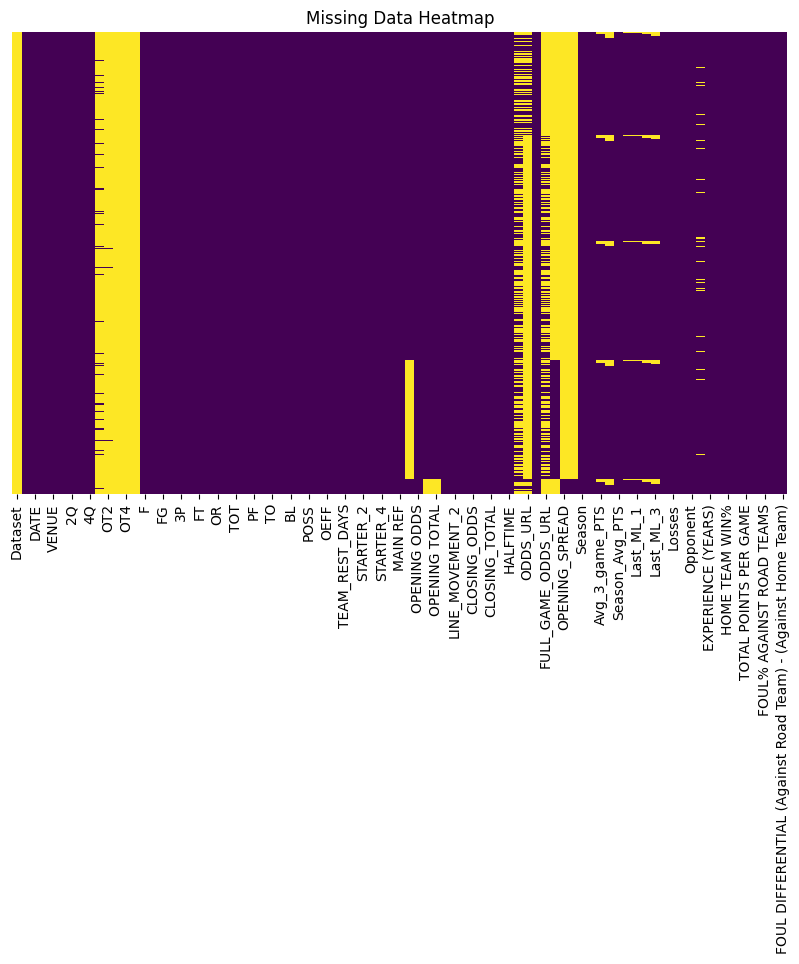

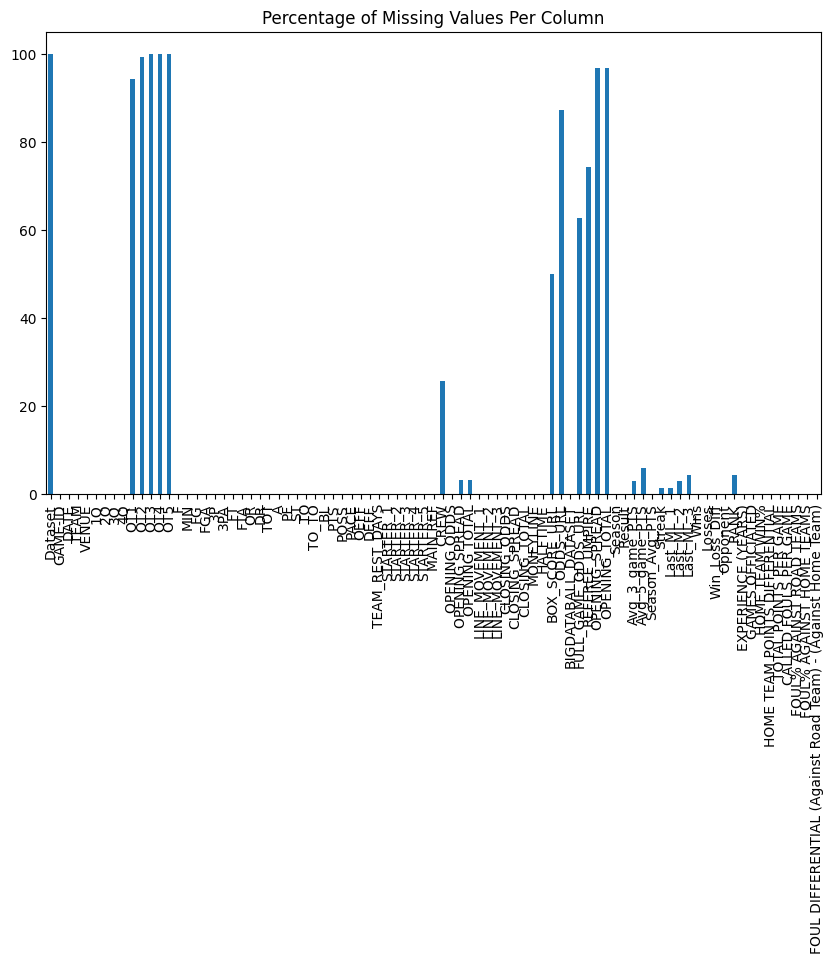

In [ ]:
total_missing = df.isna().sum()
print("Total missing values per column:\n", total_missing)

# 2. Percentage of missing values per column
percent_missing = (df.isna().sum() / len(df)) * 100
print("\nPercentage of missing values per column:\n", percent_missing)

# 3. Visualization of missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

# If you prefer a bar plot
plt.figure(figsize=(10, 6))
percent_missing.plot(kind='bar')
plt.title('Percentage of Missing Values Per Column')
plt.show()

#### Create ELO and Momentum Columns

In [36]:
# Initialize Elo ratings and momentum scores
elo_ratings = {team: 1500 for team in df['TEAM'].unique()}
momentum_scores = {team: 0 for team in df['TEAM'].unique()}
K = 10  # K-factor in Elo rating
momentum_decay = 0.9  # Decay factor for momentum

def update_elo_momentum(row):
    team = row['TEAM']
    opponent = df[(df['GAME-ID'] == row['GAME-ID']) & (df['TEAM'] != team)]['TEAM'].values[0]
    team_elo, opponent_elo = elo_ratings[team], elo_ratings[opponent]

    # Calculate expected outcomes
    expected_team = 1 / (1 + 10 ** ((opponent_elo - team_elo) / 400))

    # Actual outcome
    actual_team = 1 if row['PTS'] > df[(df['GAME-ID'] == row['GAME-ID']) & (df['TEAM'] == opponent)]['PTS'].values[0] else 0

    # Update Elo ratings
    elo_ratings[team] += K * (actual_team - expected_team)
    elo_ratings[opponent] += K * ((1 - actual_team) - (1 - expected_team))

    # Calculate Elo difference
    elo_diff = opponent_elo - team_elo

    # Update momentum
    momentum_scores[team] = momentum_decay * momentum_scores[team] + elo_diff * actual_team

    return elo_ratings[team], momentum_scores[team]

# Apply the function
df[['Elo_Rating', 'Momentum']] = df.apply(update_elo_momentum, axis=1, result_type='expand')
df[COLS + ['Elo_Rating', 'Momentum']].head(10)


,GAME-ID,DATE,TEAM,1Q,2Q,3Q,4Q,F,MIN,FG,...,OPENING ODDS,OPENING SPREAD,OPENING TOTAL,CLOSING_ODDS,CLOSING_SPREAD,CLOSING_TOTAL,MONEYLINE,HALFTIME,Elo_Rating,Momentum
0,21900001,2019-10-22,New Orleans,30,31,25,31,122,265.0,43,...,231.5,6.0,231.5,229.5,6.5,229.5,234,113o15,1495.000000,0.0
1,21900001,2019-10-22,Toronto,27,29,32,29,130,265.0,42,...,-6 -08,-6.0,231.5,-6.5 -15,-6.5,229.5,-285,-6 -20,1509.856128,-10.0
2,21900002,2019-10-22,LA Lakers,25,29,31,17,102,240.0,37,...,227,1.0,227.0,-3.5 -05,-3.5,223.5,-167,-5,1495.000000,0.0
3,21900002,2019-10-22,LA Clippers,22,40,23,27,112,240.0,42,...,-1 -15,-1.0,227.0,223.5,3.5,223.5,146,110.5o15,1509.856128,-10.0
25,21900013,2019-10-23,Portland,27,23,24,26,100,240.0,36,...,-2 -05,-2.0,219.5,217.5o11,1.5,217.5,101,-1 EVEN,1495.000000,0.0
24,21900013,2019-10-23,Denver,24,30,19,35,108,240.0,34,...,219.5,2.0,219.5,-1.5 -15,-1.5,217.5,-121,106o20,1509.856128,-10.0
23,21900012,2019-10-23,Phoenix,25,29,32,38,124,240.0,49,...,233,2.0,233.0,-1.5,-1.5,232.5,-120,-2,1505.000000,0.0
22,21900012,2019-10-23,Sacramento,29,30,17,19,95,240.0,34,...,-2,-2.0,233.0,232.5,1.5,232.5,100,114.5,1490.143872,0.0
21,21900011,2019-10-23,Utah,23,26,19,32,100,240.0,40,...,-9.5 -13,-9.5,222.0,-9 -05,-9.0,221.0,-430,-4.5 -20,1505.000000,0.0
19,21900010,2019-10-23,San Antonio,22,37,24,37,120,240.0,42,...,-9.5,-9.5,214.0,-10.5,-10.5,214.5,-580,-3.5 -15,1505.000000,0.0


## Modelling

### Train and tune model

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.6, gamma=7, learning_rate=0.035, max_depth=9, min_child_weight=8, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.5, subsample=0.85; total time=   3.8s
[CV] END colsample_bytree=0.6, gamma=7, learning_rate=0.035, max_depth=9, min_child_weight=8, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.5, subsample=0.85; total time=   4.0s
[CV] END colsample_bytree=0.6, gamma=7, learning_rate=0.035, max_depth=9, min_child_weight=8, n_estimators=1000, reg_alpha=0.1, reg_lambda=0.5, subsample=0.85; total time=   3.4s
Best hyperparameters: {'colsample_bytree': 0.6, 'gamma': 7, 'learning_rate': 0.035, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.85}
Accuracy: 0.6798


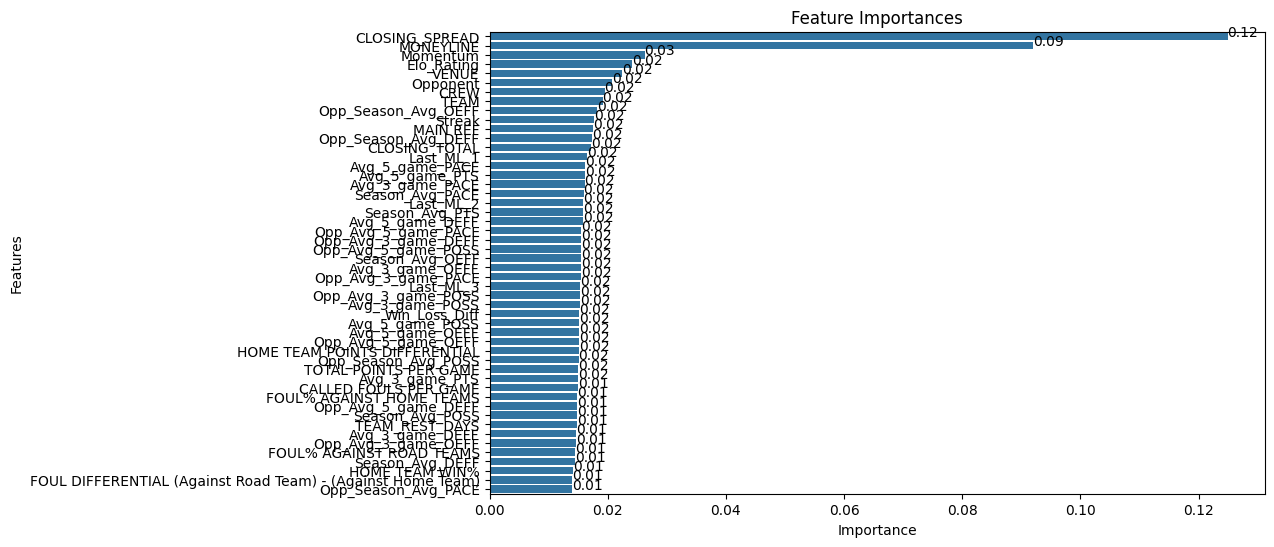

In [38]:
X = df[(df['DATE'] <= pd.to_datetime('2023-08-01'))]
y = X[TARGET]
X = X[TRAIN_COLS]
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].replace('even', '-100', regex=True)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].fillna(0).astype(int)
X['MAIN REF'] = X['MAIN REF'].astype('category')
X['CREW'] = X['CREW'].astype('category')
X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
X['TEAM'] = X['TEAM'].astype('category')
X['Opponent'] = X['Opponent'].astype('category')
X['VENUE'] = (X['VENUE'] == 'H')*1


# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

# XGBoost Classifier
clf = xgb.XGBClassifier(tree_method="hist", sampling_method='gradient_based', enable_categorical=True, device="cuda", verbosity=1)

#{'colsample_bytree': 0.6, 'gamma': 7, 'learning_rate': 0.035, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.85}
param_grid = {
    'max_depth': [9],
    'learning_rate': [0.035],
    'n_estimators': [1000],
    'gamma': [7],
    'subsample': [0.85],
    'colsample_bytree': [0.6],
    'min_child_weight': [8],
    'reg_lambda': [0.5],
    'reg_alpha': [0.1]

    # Add other parameters if needed
}

# Grid search with cross-validation
grid_clf = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', n_jobs=1, verbose=2)
grid_clf.fit(X_train, y_train)

# Best hyperparameters and model
print("Best hyperparameters:", grid_clf.best_params_)
best_model = grid_clf.best_estimator_

# Evaluate on test set
accuracy = best_model.score(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')

# Assuming you have these lists
feature_names = TRAIN_COLS
importances = best_model.feature_importances_

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Optional: Add value labels on each bar
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}')

plt.show()


## Testing

### Helper functions for testing

In [39]:
def american_odds_to_probability(odds):
    if odds > 0:
        probability = 100 / (odds + 100)
    else:
        probability = -odds / (-odds + 100)
    return probability

def calculate_profit(odds, size):
    if odds > 0:
        profit = (odds / 100) * size
    else:
        profit = (100 / -(odds + 0.0000001)) * size
    return profit

def kelly_criterion(bankroll, probability, odds, temper=1):
    """
    Calculate the optimal bet size using the Kelly Criterion.

    :param bankroll: Total amount of money you have to bet with.
    :param probability: The probability of the bet winning (from 0 to 1).
    :param odds: The odds being offered on the bet (in decimal format).
    :return: The recommended bet size according to the Kelly Criterion.
    """
    # Convert American odds to decimal if necessary
    if odds > 0:
        odds = (odds / 100) + 1
    elif odds < 0:
        odds = (100 / -odds) + 1

    # Calculate the Kelly bet fraction
    b = odds - 1  # Decimal odds minus 1
    q = 1 - probability  # Probability of losing
    kelly_fraction = (b * probability - q) / b

    # Calculate the recommended bet
    recommended_bet = (temper * kelly_fraction) * bankroll

    return recommended_bet

def combine_parlay_odds(odds_list):
    total_multiplier = 1
    for odds in odds_list:
        if odds > 0:  # Positive odds
            total_multiplier *= (odds / 100) + 1
        else:  # Negative odds
            total_multiplier *= 1 - (100 / (odds + 0.0000001))

    # Calculate parlay odds
    if total_multiplier >= 2:
        parlay_odds = (total_multiplier - 1) * 100
    else:
        parlay_odds = -100 / ((total_multiplier - 1) + 0.00000001)

    return round(parlay_odds)
def print_wrapper(func):
    ansi_reset = '\033[0m'
    ansi_black = '\033[90m'
    ansi_red = '\033[91m'
    ansi_green = '\033[92m'
    ansi_yellow = '\033[93m'
    ansi_blue = '\033[94m'
    ansi_pink = '\033[95m'
    ansi_teal = '\033[96m'
    ansi_gray = '\033[97m'
    ansi_warning = '\033[31;1;4m'
    ansi_error = '\033[31;100m'
    def wrapped_func(*args,**kwargs):
        new_args = args + tuple()
        new_kwargs = kwargs.copy()
        for kwarg, kwvalue in kwargs.items(): # Loop through the keyword arguments
            if kwarg == "color":
                if kwvalue == "black":
                    color = ansi_black
                elif kwvalue == "red":
                    color = ansi_red
                elif kwvalue == "green":
                    color = ansi_green
                elif kwvalue == "yellow":
                    color = ansi_yellow
                elif kwvalue == "blue":
                    color = ansi_blue
                elif kwvalue == "pink":
                    color = ansi_pink
                elif kwvalue == "teal":
                    color = ansi_teal
                elif kwvalue == "gray":
                    color = ansi_gray
                elif kwvalue == "warning":
                    color = ansi_warning
                elif kwvalue == "error":
                    color = ansi_error
                new_kwargs = kwargs.copy() # Make a copy of the keyword arguments dict
                del new_kwargs["color"] # Remove color from the keyword arguments dict
        try: # Is the variable color defined?
            color
        except NameError:
            pass
            # no color was specified
        else:
            new_args = ()
            for arg in args:
                new_args += (f"{color}{arg}{ansi_reset}",) # Apply the ANSI escape codes to each non-keyword argument
        return func(*new_args,**new_kwargs)
    return wrapped_func

print = print_wrapper(print) # Apply the wrapper to the print() function

def probability_to_american_odds(probability):
    if probability < 0 or probability > 1:
        raise ValueError("Probability must be between 0 and 1")

    if probability == 0.5:
        return 100  # Even odds

    if probability > 0.5:
        return int(-100 * (probability / (1 - probability)))
    else:
        return int(100 * ((1 - probability) / probability))

def odds_to_str(odds):
  if odds <= 0:
    return odds
  else:
    return f'+{odds}'

### Backtesting over games so far this season

2023-10-24 00:00:00...
	Wanted to win 2.12 betting 1.68
		Phoenix to beat Golden State at +126 - our model pinned it at -112
Results: bankroll start: 100 end: 100 for profit of: 0, win rate = 0.00

2023-10-25 00:00:00...
	Won 2.18 betting 9.79
		Miami to beat Detroit at -450 - our model pinned it at -233
	Lost 11.95 trying to win 18.4
		Houston to beat Orlando at +154 - our model pinned it at -127
	Wanted to win 12.6 betting 8.29
		Charlotte to beat Atlanta at +152 - our model pinned it at -164
	Won 2.89 betting 3.01
		New Orleans to beat Memphis at -104 - our model pinned it at -177
	Won 7.22 betting 5.82
		Oklahoma City to beat Chicago at +124 - our model pinned it at -114
	Won 3.11 betting 13.06
		LA Clippers to beat Portland at -420 - our model pinned it at -287
	Won 5.84 betting 7.24
		Sacramento to beat Utah at -124 - our model pinned it at -159
Results: bankroll start: 100 end: 109.29 for profit of: 9.29, win rate = 0.83

2023-10-26 00:00:00...
Results: bankroll start: 109.29 en

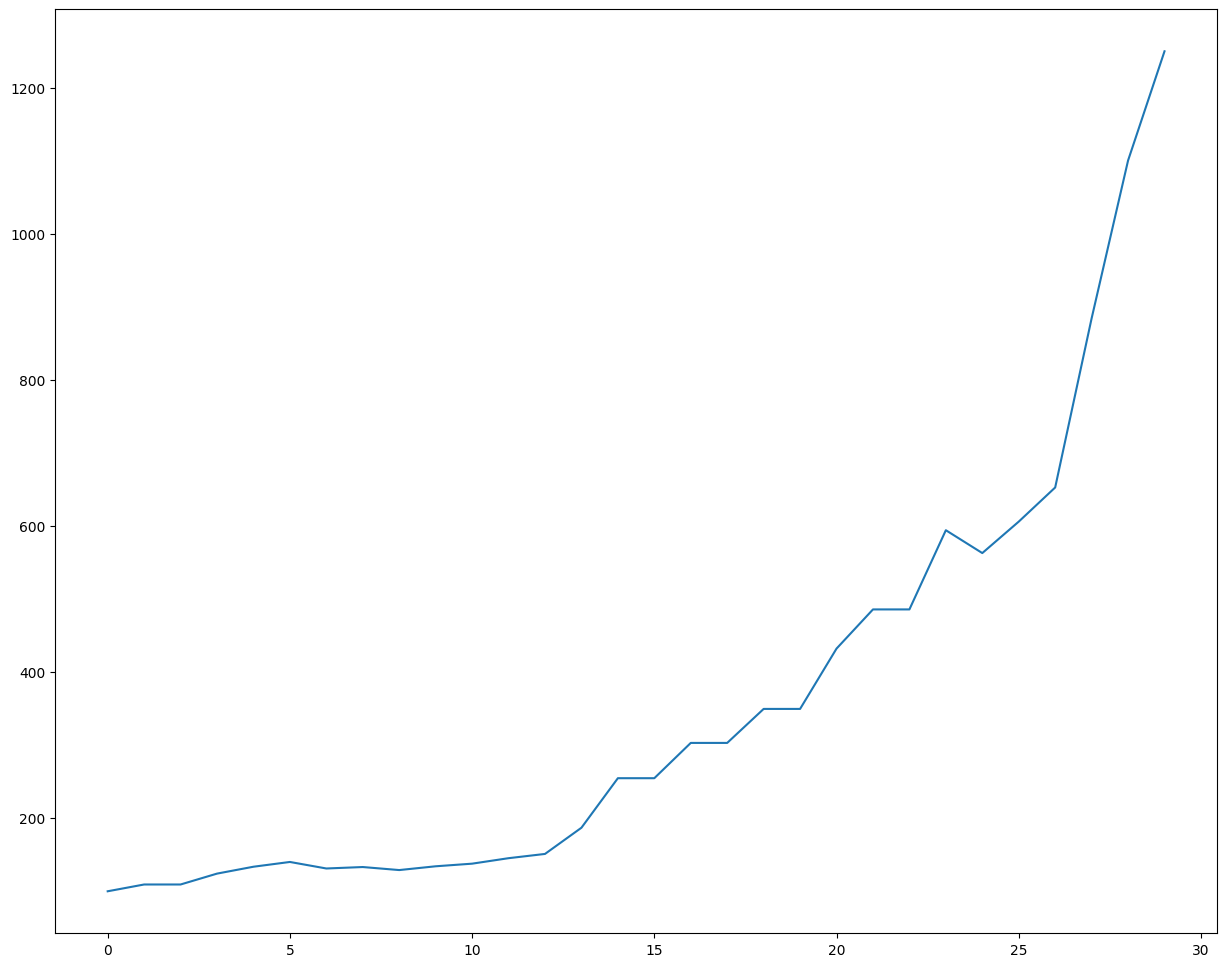

Final Bankroll: 1249.9299999999998
Total Profit: 1149.9299999999998


In [40]:
thresh = 0.5

def process_data_frame(df):
    df['DATE'] = pd.to_datetime(df['DATE'])
    return df.sort_values('DATE')

def update_bankroll(bankroll, profit):
    bankroll += profit
    return max(bankroll, 0)  # Prevents negative bankroll

def print_bet_results(date, wins, losses, total, bankroll, start, hit_all, all_odds, hit_all_all, all_all_odds):
    win_rate = wins / total if total > 0 else 0

    if hit_all and total > 1:
      print(f'\tBANGGG!!! Hit a {total} leg parlay at +{combine_parlay_odds(all_odds)} - pays {round(calculate_profit(combine_parlay_odds(all_odds), bankroll*0.1), 2)}')
    if hit_all_all and total > 1:
      print(f'\t HOLY SHIT WE CLEARED A {total} LEG SLATE AT +{combine_parlay_odds(all_all_odds)} PAID {round(calculate_profit(combine_parlay_odds(all_all_odds), 10), 2)}')
    print(f'Results: bankroll start: {round(start,2)} end: {round(bankroll,2)} for profit of: {round(bankroll - start, 2)}, win rate = {win_rate:.2f}\n')

def backtest_model(df, model, feature_cols, label_col, odds_col, start_date, end_date, initial_bankroll, bet_size):
    df = process_data_frame(df)
    bankroll = initial_bankroll
    bet_results = []
    current_date = pd.to_datetime(start_date)

    while current_date <= pd.to_datetime(end_date):
        print(f'{current_date}...')
        day_data = df[df['DATE'] == current_date]
        start_bankroll = bankroll
        day_profit = 0
        if not day_data.empty and bankroll > 0:
            X = day_data[feature_cols]
            X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].replace('even', '-100', regex=True)
            X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].fillna(0).astype(int)
            X['MAIN REF'] = X['MAIN REF'].astype('category')
            X['CREW'] = X['CREW'].astype('category')
            X['TEAM'] = X['TEAM'].astype('category')
            X['Opponent'] = X['Opponent'].astype('category')
            X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
            X['VENUE'] = (X['VENUE'] == 'H')*1
            y = day_data[label_col]
            probabilities = model.predict_proba(X)
            predictions = probabilities[:, 1] >= thresh

            #matchups = [(team, prob1, opp, prob2)]
            do_bet = {team: model.predict_proba(X[X['TEAM'] == team])[:, 1] > model.predict_proba(X[X['TEAM'] == opp])[:, 1] for team, opp in zip(X['TEAM'], X['Opponent'])}
            normed_odds = {team: model.predict_proba(X[X['TEAM'] == team])[:, 1]/(model.predict_proba(X[X['TEAM'] == team])[:, 1] + model.predict_proba(X[X['TEAM'] == opp])[:, 1]) for team, opp in zip(X['TEAM'], X['Opponent'])}
            #print(do_bet)
            wins, losses, profit, num_bets = 0, 0, 0, 0
            all_odds = []
            all_all_odds = []
            hit_all = True
            hit_all_all = True
            made_a_bet_2 = 0
            # SUBTRACT ONE FOR THE PARLAY RIGHT AWAY
            made_a_bet = False

            # for all the options today
            for pred, actual, odds, prob, team, opp in zip(predictions, y, day_data[odds_col], probabilities[:, 1], X['TEAM'].values, X['Opponent'].values):
                odds = -100 if odds == 'even' else int(odds)
                # only look at predicted winners
                if pred:

                    # get odds as integer

                    made_a_bet = True
                    # get optimal bet size
                    bet_size = round(kelly_criterion(start_bankroll, normed_odds[team][0], odds, 0.5), 2)

                    # if we can afford to bet on this
                    if (bankroll - bet_size) >= 0:

                        # how much would we win
                        to_win = round(calculate_profit(odds, bet_size), 2)

                        # if this crosses the probability threshold we want to bet on,
                        # and we don't want to bet on the other team:
                        if (prob > thresh) and do_bet[team] and (bet_size > 0):
                            bankroll -= bet_size
                            num_bets += 1
                            if actual:
                                print(f'\tWon {to_win} betting {bet_size}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(prob))}', color='green')
                                day_profit += (to_win + bet_size)
                                wins += 1
                            else:
                                print(f'\tLost {bet_size} trying to win {to_win}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(prob))}', color='red')
                                losses += actual != pred
                                hit_all = False
                            all_odds.append(odds)
                        if (prob > thresh) and not do_bet[team] and (bet_size > 0) and actual:
                              print(f'\tWanted to win {to_win} betting {bet_size}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(prob))}', color='warning')

                if do_bet[team] and ((bet_size < 0) or (prob < 0.5)):
                  made_a_bet_2 += 1
                  all_all_odds.append(int(odds))
                  if not actual:
                    hit_all_all = False



            # if made_a_bet and len(all_odds) > 2:
            #   if hit_all:
            #     total_odds = combine_parlay_odds(all_odds)
            #     bankroll += round(calculate_profit(combine_parlay_odds(all_odds), 10), 2)
            #   else:
            #     bankroll -= 10

            # if made_a_bet_2 > 1:
            #   if hit_all_all:
            #     total_odds = combine_parlay_odds(all_all_odds)
            #     bankroll += round(calculate_profit(combine_parlay_odds(all_all_odds), 10), 2)
            #   else:
            #     bankroll -= 10

            bankroll += day_profit
            print_bet_results(current_date, wins, losses, num_bets, bankroll, start_bankroll, hit_all, all_odds, hit_all_all, all_all_odds)
            bet_results.append(bankroll)

        current_date += pd.Timedelta(days=1)

    return bankroll, bankroll - initial_bankroll, bet_results

# Example usage with defined constants
final_bankroll, total_profit, bet_results = backtest_model(
    df=df,
    model=best_model,
    feature_cols=TRAIN_COLS,  # feature columns
    label_col='Result',
    odds_col='MONEYLINE',
    start_date='2023-10-24',
    end_date='2023-11-25',
    initial_bankroll=100,
    bet_size=2
)
plt.subplots(figsize=(15,12))
plt.plot(bet_results)
plt.show()
print(f"Final Bankroll: {final_bankroll}")
print(f"Total Profit: {total_profit}")


## Today

### Get data

In [42]:
pre_tdf = df[(df['Season'] == 2024)]
raw_tdf = pd.read_excel(f'{live_data_dir}/{TODAY_FILE}')
raw_tdf.columns = t_cleaned_cols

### Build the dataframe

In [43]:
tdf = raw_tdf
tdf['DATE'] = tdf['DATE'].astype('datetime64[ns]')
tdf = tdf.sort_values('DATE')
tdf['Season'] = raw_tdf['BIGDATABALL_DATASET'].map(SEASON_MAP)

# Step 1: Result of the Game
def assign_results(group):
    group['MAIN REF'] = [group['MAIN REF'].iloc[0]]*2
    if group.iloc[0]['PTS'] > group.iloc[1]['PTS']:
        group['Result'] = [1, 0]
    else:
        group['Result'] = [0, 1]

    group['Opp_Avg_3_game_PTS'] = [group.iloc[1]['Avg_3_game_PTS'], group.iloc[0]['Avg_3_game_PTS']]
    group['Opp_Avg_2_game_PTS'] = [group.iloc[1]['Avg_5_game_PTS'], group.iloc[0]['Avg_5_game_PTS']]
    group['Opp_Season_Avg_PTS'] = [group.iloc[1]['Season_Avg_PTS'], group.iloc[0]['Season_Avg_PTS']]

    group['Opp_Avg_3_game_POSS'] = [group.iloc[1]['Avg_3_game_POSS'], group.iloc[0]['Avg_3_game_POSS']]
    group['Opp_Avg_5_game_POSS'] = [group.iloc[1]['Avg_5_game_POSS'], group.iloc[0]['Avg_5_game_POSS']]
    group['Opp_Season_Avg_POSS'] = [group.iloc[1]['Season_Avg_POSS'], group.iloc[0]['Season_Avg_POSS']]

    group['Opp_Avg_3_game_PACE'] = [group.iloc[1]['Avg_3_game_PACE'], group.iloc[0]['Avg_3_game_PACE']]
    group['Opp_Avg_5_game_PACE'] = [group.iloc[1]['Avg_5_game_PACE'], group.iloc[0]['Avg_5_game_PACE']]
    group['Opp_Season_Avg_PACE'] = [group.iloc[1]['Season_Avg_PACE'], group.iloc[0]['Season_Avg_PACE']]

    group['Opp_Avg_3_game_DEFF'] = [group.iloc[1]['Avg_3_game_DEFF'], group.iloc[0]['Avg_3_game_DEFF']]
    group['Opp_Avg_5_game_DEFF'] = [group.iloc[1]['Avg_5_game_DEFF'], group.iloc[0]['Avg_5_game_DEFF']]
    group['Opp_Season_Avg_DEFF'] = [group.iloc[1]['Season_Avg_DEFF'], group.iloc[0]['Season_Avg_DEFF']]

    group['Opp_Avg_3_game_OEFF'] = [group.iloc[1]['Avg_3_game_OEFF'], group.iloc[0]['Avg_3_game_OEFF']]
    group['Opp_Avg_5_game_OEFF'] = [group.iloc[1]['Avg_5_game_OEFF'], group.iloc[0]['Avg_5_game_OEFF']]
    group['Opp_Season_Avg_OEFF'] = [group.iloc[1]['Season_Avg_OEFF'], group.iloc[0]['Season_Avg_OEFF']]

    return group


# Step 2: Average Points
tdf['Avg_3_game_PTS'] = tdf.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.shift(1).rolling(3).mean())
tdf['Avg_5_game_PTS'] = tdf.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.shift(1).rolling(5).mean())
tdf['Season_Avg_PTS'] = tdf.groupby(['TEAM', 'Season'])['PTS'].transform('mean')

tdf['Avg_3_game_POSS'] = tdf.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.shift(1).rolling(3).mean())
tdf['Avg_5_game_POSS'] = tdf.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.shift(1).rolling(5).mean())
tdf['Season_Avg_POSS'] = tdf.groupby(['TEAM', 'Season'])['POSS'].transform('mean')

tdf['Avg_3_game_PACE'] = tdf.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.shift(1).rolling(3).mean())
tdf['Avg_5_game_PACE'] = tdf.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.shift(1).rolling(5).mean())
tdf['Season_Avg_PACE'] = tdf.groupby(['TEAM', 'Season'])['PACE'].transform('mean')

tdf['Avg_3_game_OEFF'] = tdf.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.shift(1).rolling(3).mean())
tdf['Avg_5_game_OEFF'] = tdf.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.shift(1).rolling(5).mean())
tdf['Season_Avg_OEFF'] = tdf.groupby(['TEAM', 'Season'])['OEFF'].transform('mean')

tdf['Avg_3_game_DEFF'] = tdf.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.shift(1).rolling(3).mean())
tdf['Avg_5_game_DEFF'] = tdf.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.shift(1).rolling(5).mean())
tdf['Season_Avg_DEFF'] = tdf.groupby(['TEAM', 'Season'])['DEFF'].transform('mean')


# Apply the function to each game group
tdf = tdf.groupby('GAME-ID').apply(assign_results)
# Reset index if needed
tdf.reset_index(drop=True, inplace=True)

# Shift the Result column for streak calculation
tdf['Prev_Result'] = tdf.groupby(['TEAM', 'Season'])['Result'].shift()

# Step 3: Win/Loss Streak
def calculate_streak(group):
    streak = group['Prev_Result'].diff().ne(0).cumsum()
    group['Streak'] = streak.groupby(streak).cumcount()
    group['Streak'] *= group['Prev_Result'].map({1: 1, 0: -1})
    return group

tdf = tdf.groupby(['TEAM', 'Season']).apply(calculate_streak)

# Step 4: Last 3 Games Moneylines
tdf['Last_ML_1'] = tdf.groupby(['TEAM'])['MONEYLINE'].shift(1)
tdf['Last_ML_2'] = tdf.groupby(['TEAM'])['MONEYLINE'].shift(2)
tdf['Last_ML_3'] = tdf.groupby(['TEAM'])['MONEYLINE'].shift(3)

# Step 5: Current Number of Wins - Losses
tdf['Wins'] = tdf.groupby(['TEAM'])['Result'].cumsum()
tdf['Losses'] = tdf.groupby(['TEAM'])['Result'].transform('count') - tdf['Wins']
tdf['Win_Loss_Diff'] = tdf['Wins'] - tdf['Losses']

# Step 6: Current Opponent
tdf['Opponent'] = tdf.groupby('GAME-ID')['TEAM'].shift(-1).fillna(tdf.groupby('GAME-ID')['TEAM'].shift())

# Clean up and remove the temporary 'Prev_Result' column
tdf.drop('Prev_Result', axis=1, inplace=True)

ref_map = {team: details[0] for team, details in TODAY_MAP.items()}
moneyline_map = {team: details[1] for team, details in TODAY_MAP.items()}
venue_map = {team: details[2] for team, details in TODAY_MAP.items()}
opp_map = {team: details[3] for team, details in TODAY_MAP.items()}
spread_map = {team: details[4] for team, details in TODAY_MAP.items()}
total_map = {team: details[5] for team, details in TODAY_MAP.items()}


tdf['DATE'] = tdf['DATE'].astype('datetime64[ns]')
tdf['MAIN REF'] = tdf['TEAM'].map(ref_map)
tdf['MONEYLINE'] = tdf['TEAM'].map(moneyline_map)
tdf['MONEYLINE'] = tdf['TEAM'].map(moneyline_map)
tdf['CLOSING_SPREAD'] = tdf['TEAM'].map(spread_map)
tdf['CLOSING_TOTAL'] = tdf['TEAM'].map(total_map)
tdf['Opponent'] = tdf['TEAM'].map(opp_map)
refs = pd.concat([refs_2019, refs_2020, refs_2021, refs_2022, refs_2023])
tdf = tdf.merge(refs.groupby('REFEREE').mean(), how='left', left_on='MAIN REF', right_on='REFEREE')
tdf = tdf.sort_values('DATE')
#tdf[['MONEYLINE', 'DATE']].head(10)

### Process dataset and get predictions

In [44]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
t_teams = list(TODAY_MAP.keys())

# Sort df2 by 'name' and 'DATE' in descending  (pre_tdf is the preprocessed
# dataframe with the learned ELO and momentup columns)
temp = pre_tdf.sort_values(by=['TEAM', 'DATE'], ascending=[True, False])

# Drop duplicates, keep the first (latest) entry for each 'name'
temp = temp.drop_duplicates(subset='TEAM')

# Merge df1 with the processed df2
temp = pd.merge(tdf, temp[['TEAM', 'Elo_Rating', 'Momentum']], on='TEAM', how='left', suffixes=('_x', '_y'))

# look at the latest
temp = temp.sort_values(by=['TEAM', 'DATE'], ascending=[True, False])
temp = temp.drop_duplicates(subset='TEAM')[t_train_cols]

temp = temp[temp['TEAM'].isin(t_teams)]
temp.columns = train_cols_final

X = temp.copy()
X['MONEYLINE'] = X['TEAM'].map(moneyline_map)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].replace('Even', '-100', regex=True)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].fillna(0).astype(float)
X['MAIN REF'] = X['MAIN REF'].astype('category')
X['CREW'] = X['CREW'].astype('category')
X['TEAM'] = X['TEAM'].astype('category')
X['Opponent'] = X['Opponent'].astype('category')
X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
X['VENUE'] = (X['VENUE'] == 'H')*1

# make predictions
probs = best_model.predict_proba(X)
odds = X['MONEYLINE'].values
booster = best_model.get_booster()
normed_odds = {team: best_model.predict_proba(X[X['TEAM'] == team])[:, 1]/(best_model.predict_proba(X[X['TEAM'] == team])[:, 1] + best_model.predict_proba(X[X['TEAM'] == opp])[:, 1]) for team, opp in zip(X['TEAM'], X['Opponent'])}
do_bet = {team: normed_odds[team] > normed_odds[opp] for team, opp in zip(X['TEAM'], X['Opponent'])}

pred_contribs = booster.predict(DMatrix(X, enable_categorical=True), pred_contribs=True)


for team, win, prob, opp, contribs, elo, mom in zip(X['TEAM'].values, best_model.predict(X), best_model.predict_proba(X)[:, 1], X['Opponent'].values, pred_contribs[:, :-1], X['Elo_Rating'].values, X['Momentum'].values):

  # get the most important features
  helpers = np.array(TRAIN_COLS)[np.argpartition(contribs, -3)[-3:]]
  detractions = (np.array(TRAIN_COLS)[np.argpartition(contribs, -3)[:3]])

  # get this team odds
  o = -100 if moneyline_map[team] == 'Even' else int(moneyline_map[team])
  odd = str(o) if o < 0 else f'+{o}'

  # get opp odds
  o2 = -100 if moneyline_map[opp] == 'Even' else int(moneyline_map[opp])
  odd2 = str(o2) if o2 < 0 else f'+{o2}'

  # get out odds
  our_line = probability_to_american_odds(normed_odds[team][0])
  our_line = str(our_line) if our_line < 0 else f'+{our_line}'

  # get our opp odds
  our_opp_line = probability_to_american_odds(normed_odds[opp][0])
  our_opp_line = str(our_opp_line) if our_opp_line < 0 else f'+{our_opp_line}'

  # get the bet sizing
  bet = kelly_criterion(100, normed_odds[team][0], o, temper=0.5)

  # tab character for spacing the prints
  tab = '&nbsp;&nbsp;&nbsp;&nbsp;'

  # make picks
  if (bet >= 0) and do_bet[team]:
    win_color = 'green'
    lose_color = 'red'
    b = f'Stright bet {round(bet, 2)}u to win {round(calculate_profit(o, round(bet, 2)),2)}u' if round(bet, 2) > 0 else 'Don\'t bet this straight - parlay only'

    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{round(normed_odds[team][0]*100, 2)}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                      <h3> Best Features: </h3>
                      <h4> - {tab + helpers[0]} </h4>
                      <h4> - {tab + helpers[1]} </h4>
                      <h4> - {tab + helpers[2]} </h4>
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{round(normed_odds[opp][0]*100, 2)}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                      <h3> Opp Mitigations: </h3>
                      <h4> - {tab + detractions[0]} </h4>
                      <h4> - {tab + detractions[1]} </h4>
                      <h4> - {tab + detractions[2]} </h4>
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')

  elif do_bet[team] and (bet < 0):
    win_color = '#E4CD05'
    lose_color = 'orange'
    b = f'Stright bet {round(bet, 2)}u to win {round(calculate_profit(o, round(bet, 2)),2)}u' if round(bet, 2) > 0 else 'Don\'t bet this straight - parlay only'
    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{round(normed_odds[team][0]*100, 2)}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                      <h3> Best Features: </h3>
                      <h4> - {tab + helpers[0]} </h4>
                      <h4> - {tab + helpers[1]} </h4>
                      <h4> - {tab + helpers[2]} </h4>
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{round(normed_odds[opp][0]*100, 2)}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                      <h3> Opp Mitigations: </h3>
                      <h4> - {tab + detractions[0]} </h4>
                      <h4> - {tab + detractions[1]} </h4>
                      <h4> - {tab + detractions[2]} </h4>
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')


<IPython.core.display.Javascript object>

___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


#### Optional Visualizations

In [ ]:
num_features = len(TRAIN_COLS)
num_inferences = len(pred_contribs)

# Creating subplots
fig, axes = plt.subplots(num_inferences, 1, figsize=(15, 5 * num_inferences))
if num_inferences == 1:
    axes = [axes]

# Plotting each inference
for i,(_, row) in enumerate(X.iterrows()):
    ax = axes[i]
    y_pos = np.arange(num_features + 1)
    contributions = pred_contribs[i]

    ax.barh(y_pos, contributions, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(TRAIN_COLS + ['BIAS'])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Feature Contributions')
    ax.set_title(f'{row["TEAM"]}')

plt.tight_layout()
plt.show()

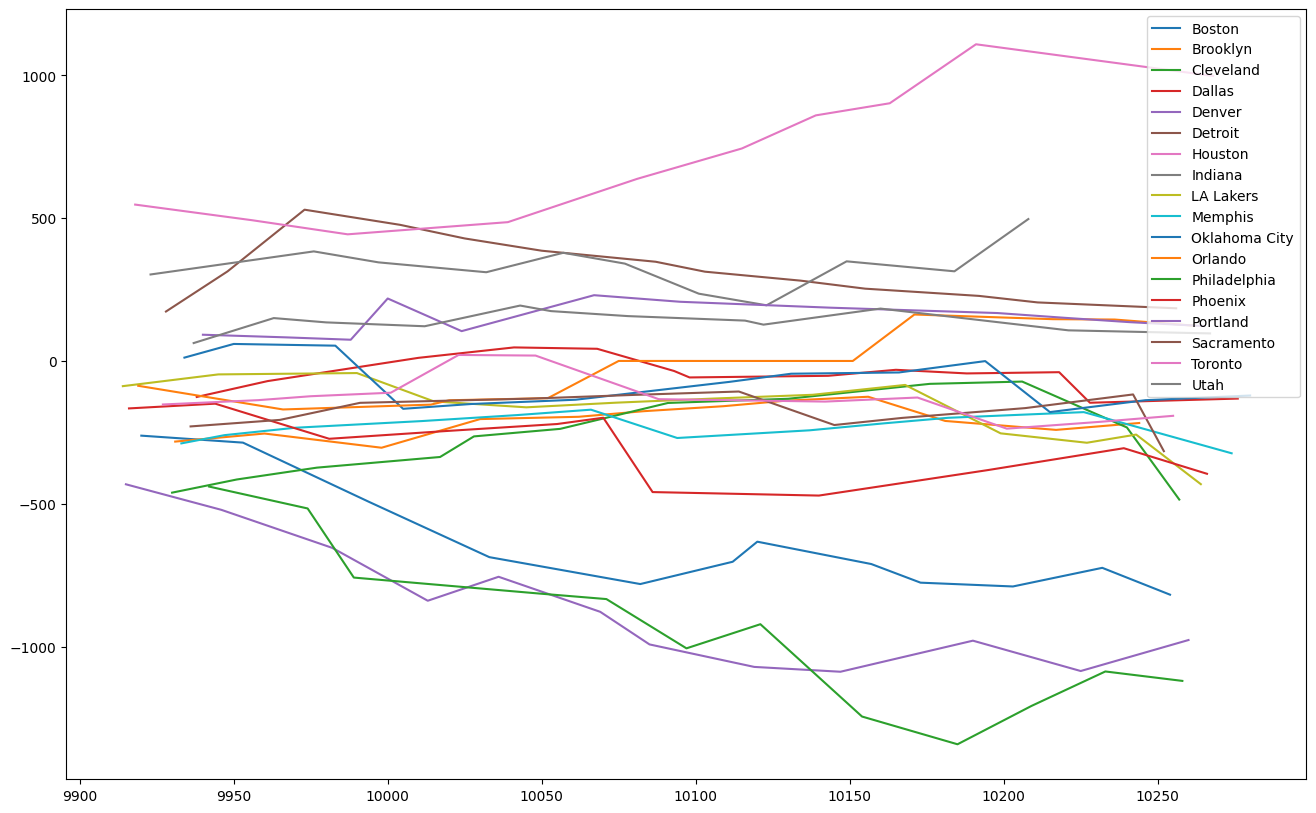

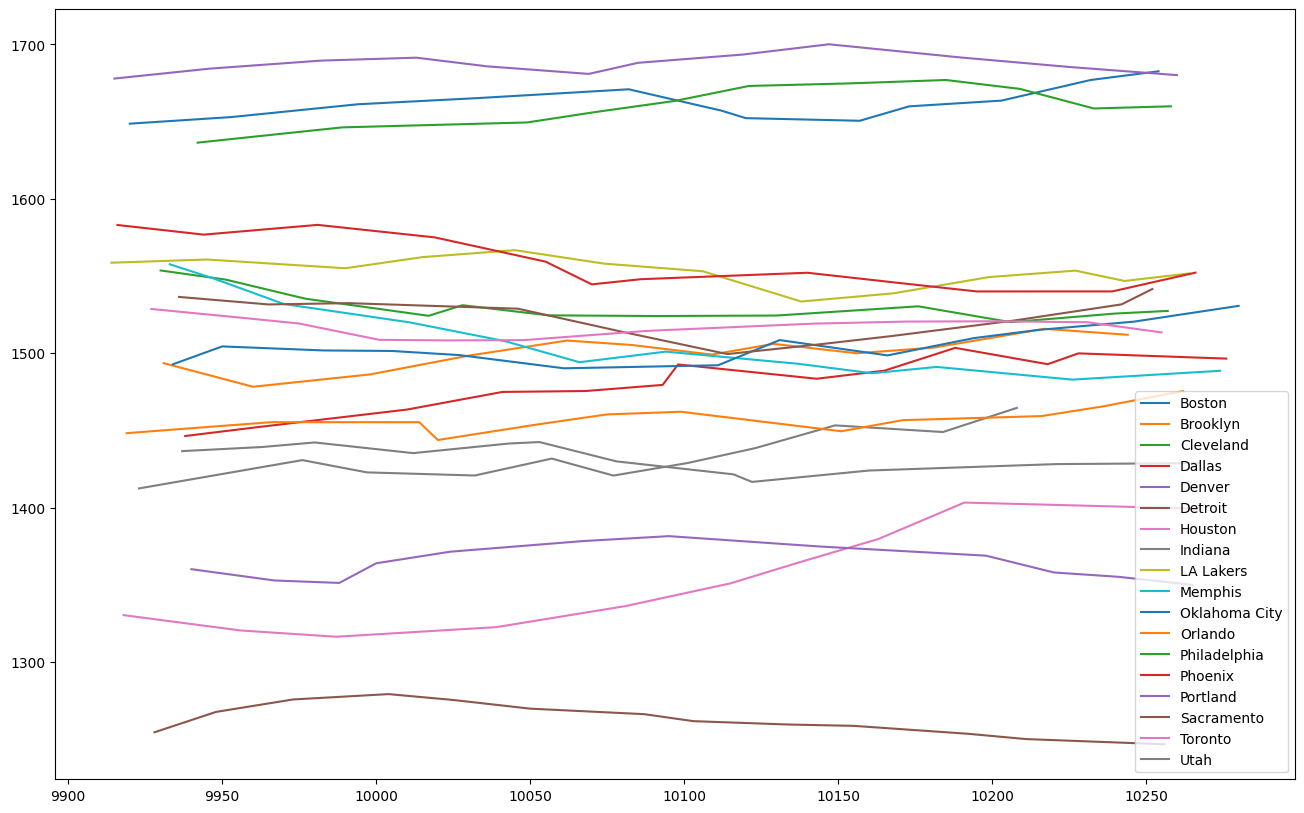

In [ ]:
plt.subplots(figsize=(16, 10))
pre_tdf[pre_tdf['TEAM'].isin(t_teams)].groupby('TEAM')['Momentum'].plot()
plt.legend()
plt.show()

plt.subplots(figsize=(16, 10))
pre_tdf[pre_tdf['TEAM'].isin(t_teams)].groupby('TEAM')['Elo_Rating'].plot()
plt.legend()
plt.show()



### Bootstrapping for confidence intervals

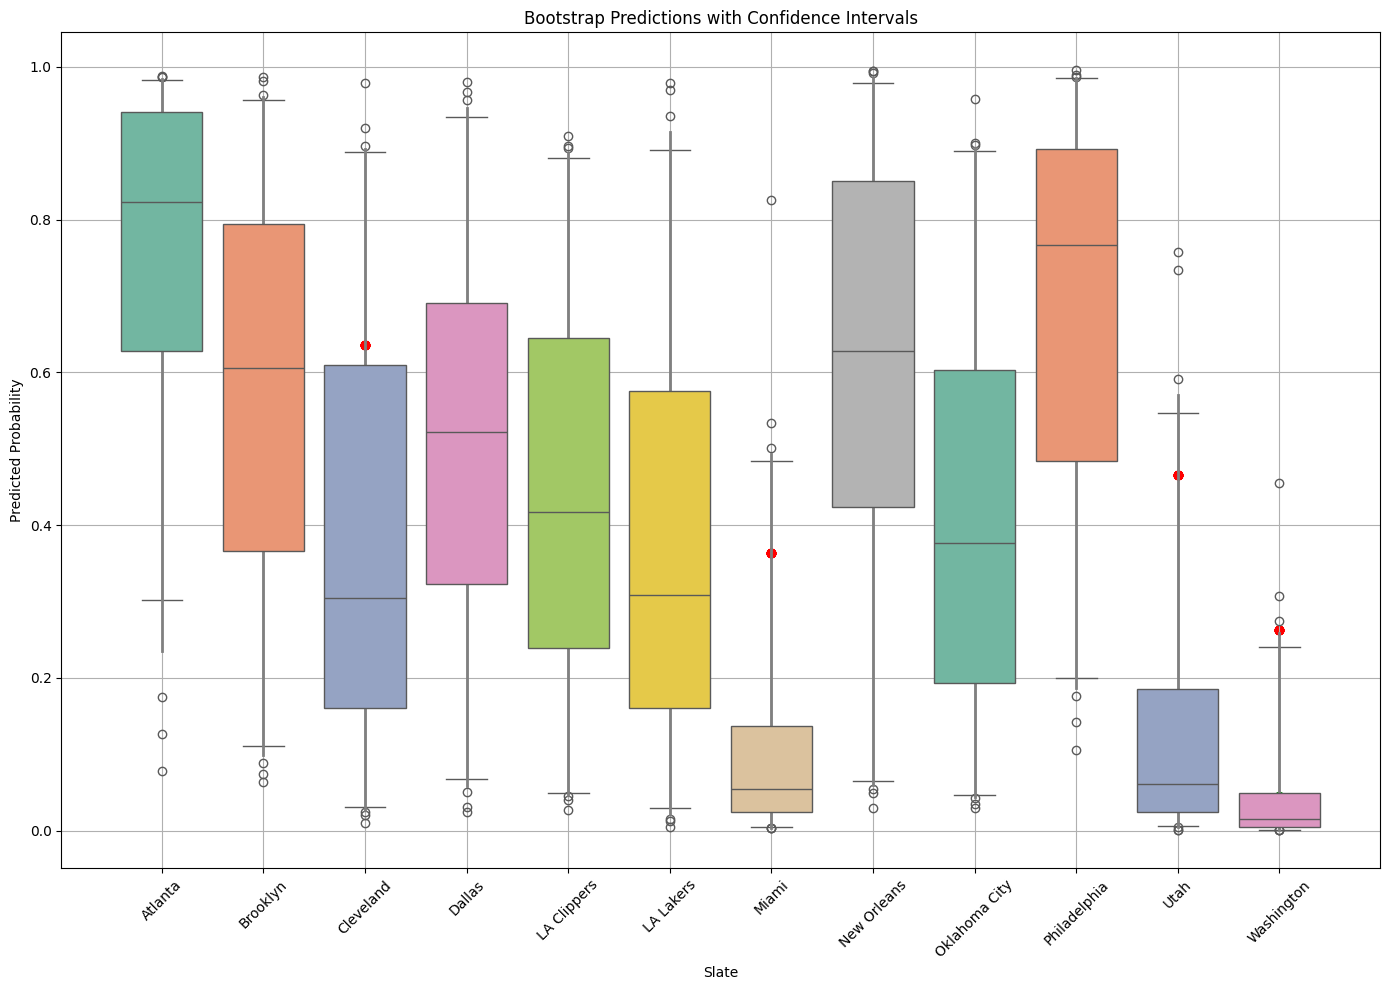

In [45]:
n_bootstrap_samples = 100  # Number of bootstrap samples
bootstrap_models = []

# Generate bootstrap samples and train a model on each
for _ in range(n_bootstrap_samples):
    X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=int(0.5*len(X_train)), replace=True)
    model = xgb.XGBClassifier(tree_method="hist", sampling_method='gradient_based', enable_categorical=True, device="cuda", verbosity=1, kwargs={'colsample_bytree': 0.7, 'gamma': 7, 'learning_rate': 0.02, 'max_depth': 12, 'min_child_weight': 8, 'n_estimators': 800, 'reg_alpha': 0.1, 'reg_lambda': 0.6, 'subsample': 0.8})
    model.fit(X_train_sample, y_train_sample)
    bootstrap_models.append(model)

#X = X.drop('prob', axis=1)
# Make predictions on the test set with each model
predictions = np.array([model.predict_proba(X)[:, 1] for model in bootstrap_models])

# Calculate the mean and 95% confidence interval for each prediction
prediction_means = predictions.mean(axis=0)
confidence_lower = np.percentile(predictions, 2.5, axis=0)
confidence_upper = np.percentile(predictions, 97.5, axis=0)

prediction_long_df = pd.DataFrame(predictions)

# Create the boxplot
plt.figure(figsize=(14, 10))
sns.boxplot(data=prediction_long_df, palette="Set2", whis=[2.5, 97.5])

# Add mean and confidence interval lines for each test sample
for i in range(prediction_means.shape[0]):
    plt.plot([i, i], [confidence_lower[i], confidence_upper[i]], color='gray', lw=2)
    plt.scatter([i], [prediction_means[i]], color='green', marker='o', label='Our Prediction')
    plt.scatter(range(len(X)), [american_odds_to_probability(x) for x in X['MONEYLINE'].values], color='red', label='Vegas')

plt.title('Bootstrap Predictions with Confidence Intervals')
plt.xlabel('Slate')
plt.xticks(range(prediction_means.shape[0]), X['TEAM'].values)
plt.ylabel('Predicted Probability')
#plt.legend()

# Customize the plot to make it more suitable for a business presentation
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.grid(True)  # Add grid for easier reading

plt.tight_layout()
plt.show()

### Bootstrapped backtesting...

2023-10-24 00:00:00...
	Wanted to win 24.41 betting 19.37
		Phoenix to beat Golden State at +126 - our model pinned it at -109
Results: bankroll start: 1150 end: 1150 for profit of: 0, win rate = 0.00

2023-10-25 00:00:00...
	Won 25.01 betting 112.53
		Miami to beat Detroit at -450 - our model pinned it at -255
	Lost 137.46 trying to win 211.69
		Houston to beat Orlando at +154 - our model pinned it at -107
	Wanted to win 144.83 betting 95.28
		Charlotte to beat Atlanta at +152 - our model pinned it at -109
	Won 33.25 betting 34.58
		New Orleans to beat Memphis at -104 - our model pinned it at -327
	Won 35.77 betting 150.24
		LA Clippers to beat Portland at -420 - our model pinned it at -308
	Won 67.1 betting 83.21
		Sacramento to beat Utah at -124 - our model pinned it at -180
	 HOLY SHIT WE CLEARED A 5 LEG SLATE AT +-195 PAID 76.92
Results: bankroll start: 1150 end: 1173.67 for profit of: 23.67, win rate = 0.80

2023-10-26 00:00:00...
Results: bankroll start: 1173.67 end: 1173.67 for

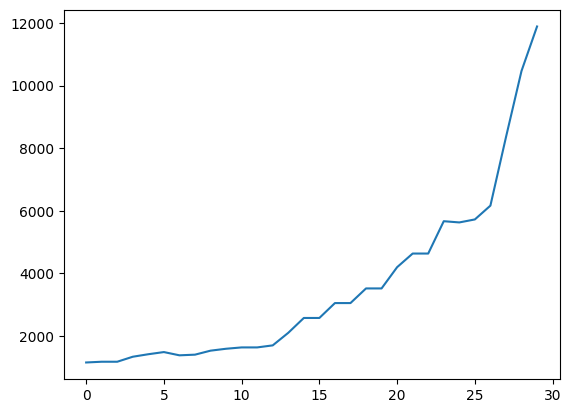

In [46]:
thresh = 0.5

def process_data_frame(df):
    df['DATE'] = pd.to_datetime(df['DATE'])
    return df.sort_values('DATE')

def update_bankroll(bankroll, profit):
    bankroll += profit
    return max(bankroll, 0)  # Prevents negative bankroll

def print_bet_results(date, wins, losses, total, bankroll, start, hit_all, all_odds, hit_all_all, all_all_odds):
    win_rate = wins / total if total > 0 else 0

    if hit_all and total > 1:
      print(f'\tBANGGG!!! Hit a {total} leg parlay at +{combine_parlay_odds(all_odds)} - pays {round(calculate_profit(combine_parlay_odds(all_odds), 10), 2)}')
    if hit_all_all and total > 1:
      print(f'\t HOLY SHIT WE CLEARED A {total} LEG SLATE AT +{combine_parlay_odds(all_all_odds)} PAID {round(calculate_profit(combine_parlay_odds(all_all_odds), 150), 2)}')
    print(f'Results: bankroll start: {round(start,2)} end: {round(bankroll,2)} for profit of: {round(bankroll - start, 2)}, win rate = {win_rate:.2f}\n')

def backtest_model(df, model, feature_cols, label_col, odds_col, start_date, end_date, initial_bankroll, bet_size):
    df = process_data_frame(df)
    bankroll = initial_bankroll
    bet_results = []
    current_date = pd.to_datetime(start_date)

    while current_date <= pd.to_datetime(end_date):
        print(f'{current_date}...')
        day_data = df[df['DATE'] == current_date]
        start_bankroll = bankroll
        day_profit = 0
        if not day_data.empty and bankroll > 0:
            X = day_data[feature_cols]
            X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].replace('even', '-100', regex=True)
            X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].fillna(0).astype(int)
            X['MAIN REF'] = X['MAIN REF'].astype('category')
            X['TEAM'] = X['TEAM'].astype('category')
            X['CREW'] = X['CREW'].astype('category')
            X['Opponent'] = X['Opponent'].astype('category')
            X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
            X['VENUE'] = (X['VENUE'] == 'H')*1
            y = day_data[label_col]
            #probabilities = model.predict_proba(X)
            preds = np.array([model.predict_proba(X)[:, 1] for model in bootstrap_models])

            # Calculate the mean and 95% confidence interval for each prediction
            probabilities = preds.mean(axis=0)
            predictions = np.array([x > 0.5 for x in probabilities])

            #matchups = [(team, prob1, opp, prob2)]
            do_bet = {team: model.predict_proba(X[X['TEAM'] == team])[:, 1] > model.predict_proba(X[X['TEAM'] == opp])[:, 1] for team, opp in zip(X['TEAM'], X['Opponent'])}
            normed_odds = {team: model.predict_proba(X[X['TEAM'] == team])[:, 1]/(model.predict_proba(X[X['TEAM'] == team])[:, 1] + model.predict_proba(X[X['TEAM'] == opp])[:, 1]) for team, opp in zip(X['TEAM'], X['Opponent'])}
            #print(do_bet)
            wins, losses, profit, num_bets = 0, 0, 0, 0
            all_odds = []
            all_all_odds = []
            hit_all = True
            hit_all_all = True

            # SUBTRACT ONE FOR THE PARLAY RIGHT AWAY
            made_a_bet = False
            made_a_bet = 0
            # for all the options today
            for pred, actual, odds, prob, team, opp in zip(predictions, y, day_data[odds_col], probabilities, X['TEAM'].values, X['Opponent'].values):

                # only look at predicted winners
                if pred:

                    # get odds as integer
                    odds = -100 if odds == 'even' else int(odds)
                    # get optimal bet size
                    bet_size = round(kelly_criterion(start_bankroll, normed_odds[team][0], odds, 0.5), 2)

                    # if we can afford to bet on this
                    if (bankroll - bet_size) >= 0:

                        # how much would we win
                        to_win = round(calculate_profit(odds, bet_size), 2)

                        # if this crosses the probability threshold we want to bet on,
                        # and we don't want to bet on the other team:
                        if (prob > thresh) and do_bet[team] and (bet_size > 0):
                            bankroll -= bet_size
                            num_bets += 1
                            if actual:
                                print(f'\tWon {to_win} betting {bet_size}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(prob))}', color='green')
                                day_profit += (to_win + bet_size)
                                wins += 1
                            else:
                                print(f'\tLost {bet_size} trying to win {to_win}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(prob))}', color='red')
                                losses += actual != pred
                                hit_all = False
                            all_odds.append(odds)
                        if (prob > thresh) and not do_bet[team] and (bet_size > 0) and actual:
                              print(f'\tWanted to win {to_win} betting {bet_size}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(prob))}', color='warning')

                if [normed_odds[team]][0] > 0.7:
                  made_a_bet += 1
                  all_all_odds.append(int(odds))
                  if not actual:
                    hit_all_all = False



            # if made_a_bet > 1:
            #   if hit_all_all:
            #     total_odds = combine_parlay_odds(all_all_odds)
            #     bankroll += round(calculate_profit(combine_parlay_odds(all_all_odds), 150), 2)
            #   else:
            #     bankroll -= 150

            bankroll += day_profit
            print_bet_results(current_date, wins, losses, num_bets, bankroll, start_bankroll, hit_all, all_odds, hit_all_all, all_all_odds)
            bet_results.append(bankroll)

        current_date += pd.Timedelta(days=1)

    return bankroll, bankroll - initial_bankroll, bet_results

# Example usage with defined constants
final_bankroll, total_profit, bet_results = backtest_model(
    df=df,
    model=best_model,
    feature_cols=TRAIN_COLS,  # feature columns
    label_col='Result',
    odds_col='MONEYLINE',
    start_date='2023-10-24',
    end_date='2023-11-25',
    initial_bankroll=1150,
    bet_size=2
)
plt.plot(bet_results)
print(f"Final Bankroll: {final_bankroll}")
print(f"Total Profit: {total_profit}")


In [47]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
t_teams = list(TODAY_MAP.keys())

# Sort df2 by 'name' and 'DATE' in descending  (pre_tdf is the preprocessed
# dataframe with the learned ELO and momentup columns)
temp = pre_tdf.sort_values(by=['TEAM', 'DATE'], ascending=[True, False])

# Drop duplicates, keep the first (latest) entry for each 'name'
temp = temp.drop_duplicates(subset='TEAM')

# Merge df1 with the processed df2
temp = pd.merge(tdf, temp[['TEAM', 'Elo_Rating', 'Momentum']], on='TEAM', how='left', suffixes=('_x', '_y'))

# look at the latest
temp = temp.sort_values(by=['TEAM', 'DATE'], ascending=[True, False])
temp = temp.drop_duplicates(subset='TEAM')[t_train_cols]

temp = temp[temp['TEAM'].isin(t_teams)]
temp.columns = train_cols_final

X = temp.copy()
X['MONEYLINE'] = X['TEAM'].map(moneyline_map)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].replace('Even', '-100', regex=True)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].fillna(0).astype(float)
X['MAIN REF'] = X['MAIN REF'].astype('category')
X['TEAM'] = X['TEAM'].astype('category')
X['CREW'] = X['CREW'].astype('category')
X['Opponent'] = X['Opponent'].astype('category')
X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
X['VENUE'] = (X['VENUE'] == 'H')*1

# make predictions
probs = best_model.predict_proba(X)

preds = np.array([model.predict_proba(X)[:, 1] for model in bootstrap_models])

# Calculate the mean and 95% confidence interval for each prediction
probabilities = preds.mean(axis=0)
predictions = np.array([x > 0.5 for x in probabilities])

X['prob'] = probabilities

odds = X['MONEYLINE'].values
booster = best_model.get_booster()
#display(X[X['TEAM'] == team])
do_bet = {team: X[X['TEAM'] == team]['prob'].values[0] > X[X['TEAM'] == opp]['prob'].values[0] for team, opp in zip(X['TEAM'], X['Opponent'])}
normed_odds = {team: X[X['TEAM'] == team]['prob'].values[0]/(X[X['TEAM'] == team]['prob'].values[0] + X[X['TEAM'] == opp]['prob'].values[0]) for team, opp in zip(X['TEAM'], X['Opponent'])}
#print(normed_odds)
#pred_contribs = booster.predict(DMatrix(X, enable_categorical=True), pred_contribs=True)


for team, win, prob, opp, elo, mom in zip(X['TEAM'].values, preds, probabilities, X['Opponent'].values, X['Elo_Rating'].values, X['Momentum'].values):

  # get the most important features
  helpers = np.array(TRAIN_COLS)[np.argpartition(contribs, -3)[-3:]]
  detractions = (np.array(TRAIN_COLS)[np.argpartition(contribs, -3)[:3]])

  # get this team odds
  o = -100 if moneyline_map[team] == 'Even' else int(moneyline_map[team])
  odd = str(o) if o < 0 else f'+{o}'

  # get opp odds
  o2 = -100 if moneyline_map[opp] == 'Even' else int(moneyline_map[opp])
  odd2 = str(o2) if o2 < 0 else f'+{o2}'

  # get out odds
  #print(normed_odds[team])
  our_line = probability_to_american_odds(normed_odds[team])
  our_line = str(our_line) if our_line < 0 else f'+{our_line}'

  # get our opp odds
  our_opp_line = probability_to_american_odds(normed_odds[opp])
  our_opp_line = str(our_opp_line) if our_opp_line < 0 else f'+{our_opp_line}'

  # get the bet sizing
  bet = kelly_criterion(100, normed_odds[team], o, temper=0.2)

  # tab character for spacing the prints
  tab = '&nbsp;&nbsp;&nbsp;&nbsp;'

  # make picks
  if (bet >= 0) and do_bet[team]:
    win_color = 'green'
    lose_color = 'red'
    b = f'Stright bet {round(bet, 2)}u to win {round(calculate_profit(o, round(bet, 2)),2)}u' if round(bet, 2) > 0 else 'Don\'t bet this straight - parlay only'

    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{round(normed_odds[team]*100, 2)}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                      <h3> Best Features: </h3>
                      <!-- <h4> - {tab + helpers[0]} </h4>
                      <h4> - {tab + helpers[1]} </h4>
                      <h4> - {tab + helpers[2]} </h4> -->
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{round(normed_odds[opp]*100, 2)}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                      <h3> Opp Mitigations: </h3>
                      <!-- <h4> - {tab + detractions[0]} </h4>
                      <h4> - {tab + detractions[1]} </h4>
                      <h4> - {tab + detractions[2]} </h4> -->
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')

  elif do_bet[team]:
    win_color = '#E4CD05'
    lose_color = 'orange'
    b = f'Stright bet {round(bet, 2)}u to win {round(calculate_profit(o, round(bet, 2)),2)}u' if round(bet, 2) > 0 else 'Don\'t bet this straight - parlay only'
    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{round(normed_odds[team]*100, 2)}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                      <h3> Best Features: </h3>
                      <!-- <h4> - {tab + helpers[0]} </h4>
                      <h4> - {tab + helpers[1]} </h4>
                      <h4> - {tab + helpers[2]} </h4> -->
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{round(normed_odds[opp]*100, 2)}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                      <h3> Opp Mitigations: </h3>
                      <!-- <h4> - {tab + detractions[0]} </h4>
                      <h4> - {tab + detractions[1]} </h4>
                      <h4> - {tab + detractions[2]} </h4> -->
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')


<IPython.core.display.Javascript object>

___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


In [5]:
import numpy as np
X = np.array([1,2,3,4,5])
print(X)
np.ones(shape=(len(X), len(X)))

[1 2 3 4 5]


array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [8]:
a = np.array([9, 4, 4, 3, 3, 9, 0, 4, 6, 0])
ind = np.partition(a, -4)[-4:]
ind

array([4, 9, 6, 9])

In [15]:
from sqlalchemy import create_engine

# Database credentials and details
username = 'postgres'
password = 'F8l1i0nt$t0ne!'
host = 'nba.chuweugicfu6.us-east-2.rds.amazonaws.com'
port = '5432'
database = 'nba'

# Example for PostgreSQL, change the dialect as per your RDS database engine
engine = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{database}')

import psycopg2
psconn = psycopg2.connect(host=host, port=port, database=database, user=username, password=password)

OperationalError: connection to server at "nba.chuweugicfu6.us-east-2.rds.amazonaws.com" (3.130.14.133), port 5432 failed: Connection timed out (0x0000274C/10060)
	Is the server running on that host and accepting TCP/IP connections?


In [8]:
import pandas as pd

# df = pd.read
df.to_sql('test', con=psconn, if_exists='replace', index=False)



OperationalError: (psycopg2.OperationalError) connection to server at "nba.chuweugicfu6.us-east-2.rds.amazonaws.com" (3.130.14.133), port 5432 failed: Connection timed out (0x0000274C/10060)
	Is the server running on that host and accepting TCP/IP connections?

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [3]:
import pandas as pd
df = pd.read_pickle('../live_data/dataframe.pkl')

In [9]:
df.to_sql('test', con=engine, if_exists='replace', index=False)

OperationalError: (psycopg2.OperationalError) connection to server at "nba.chuweugicfu6.us-east-2.rds.amazonaws.com" (3.130.14.133), port 5432 failed: Connection timed out (0x0000274C/10060)
	Is the server running on that host and accepting TCP/IP connections?

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
pip install pandas 1.5.1